# Collaborative Filtering with small dataset

The data used in this code is MovieLens Latest dataset updated 9/2018. You can download data [here](http://files.grouplens.org/datasets/movielens/ml-latest-small.zip).

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import KFold
import time
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt


import warnings
#from sklearn.exceptions import DataConversionWarning 
warnings.filterwarnings(action='ignore', category=DataConversionWarning)


#Change path to run
ratings = pd.read_csv('MovieLens/ml-latest-small/ratings.csv',sep=',',usecols=range(3))
movies = pd.read_csv('MovieLens/ml-latest-small/movies.csv',sep=',')
ratings = pd.merge(movies, ratings)

ratings.head(10)

NameError: name 'DataConversionWarning' is not defined

In [77]:
ratings_shuffle = ratings.sample(frac=1)

In [163]:
ratings_shuffle.head(10)

,movieId,title,genres,userId,rating
53798,3384,"Taking of Pelham One Two Three, The (1974)",Action|Crime,474,4.0
97134,112138,22 Jump Street (2014),Action|Comedy|Crime,89,3.0
72938,6936,Elf (2003),Children|Comedy|Fantasy,89,2.0
91021,76293,Date Night (2010),Action|Comedy|Romance,177,2.5
26762,1222,Full Metal Jacket (1987),Drama|War,36,2.5
41778,2302,My Cousin Vinny (1992),Comedy,19,3.0
60362,4144,In the Mood For Love (Fa yeung nin wa) (2000),Drama|Romance,567,4.5
69759,6036,Secret Admirer (1985),Comedy|Romance,414,3.0
82706,45880,Marie Antoinette (2006),Drama|Romance,50,2.5
45,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,135,4.0


In [61]:
# Create utility matrix
df_movie_features = ratings.pivot(index='movieId',columns='userId',values='rating').fillna(0)
M=df_movie_features.shape[0]
U=df_movie_features.shape[1]
df_movie_features.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
mat_movie_features = csr_matrix(df_movie_features.values)

In [5]:
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10, n_jobs=-1)
model_knn.fit(df_movie_features.values)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=-1, n_neighbors=10, p=2, radius=1.0)

In [6]:
distance,indice=model_knn.kneighbors(df_movie_features.values,n_neighbors=10)

In [7]:
S = np.zeros((M,M))
for i in range(0,M):
    S[i,indice[i,]]=distance[i,]
    S[i,i]=1
#print(S[0,:].sum())
print(S.shape)

(9724, 9724)


In [8]:
tmp=abs(S).sum(axis=1)
df_pred=np.dot(S,df_movie_features)/tmp[:,None]

In [9]:
rmse_knn=np.sqrt(np.nanmean(np.square(df_movie_features[df_movie_features!=0]-df_pred)))
rmse_knn

1.6844142906795845

In [10]:
mae=np.nanmean(df_movie_features[df_movie_features!=0].abs()-np.abs(df_pred))
mae

1.2960139608381611

# Cross Validation

## Item-Based CF

In [155]:
def data_process(data,item_flag):
    if item_flag: # item-based CF
        df_processed = data.pivot(index='movieId',columns='userId',values='rating').fillna(0)
    else:
        df_processed = data.pivot(index='userId',columns='movieId',values='rating').fillna(0)
    return df_processed,df_processed.shape[0]
def data_extend(data,target_data):
    df_extended=pd.DataFrame(np.zeros((target_data.shape[0],target_data.shape[1])),index=target_data.index.unique(),
                   columns=target_data.columns.unique())
    df_extended.loc[data.index,data.columns]=data
    return df_extended   

In [214]:
# cross validation
def CV(model,nneigh,nfolds,data,verbose,item_flag):
    kf=KFold(n_splits=nfolds)
    rmse_train=[]
    mae_train=[]
    rmse_test=[]
    mae_test=[]
    for j, (train_index, test_index) in enumerate(kf.split(data)):
        if not verbose:
            print("----Now processing fold: %d----" % (j+1))
        start = time.time()
        train, test = data.iloc[train_index], data.iloc[test_index]
        df_movie_features,M=data_process(data,item_flag)
        train,M_train = data_process(train,item_flag)
        test,M_test = data_process(test,item_flag)
        
        train_extend=data_extend(train,df_movie_features)
        test_extend=data_extend(test,df_movie_features)
        model.fit(train.values)
        
        #train model
        distance,indice=model.kneighbors(train.values,n_neighbors=nneigh)
        S = pd.DataFrame(np.eye(M),index=df_movie_features.index.unique(),columns=df_movie_features.index.unique())
        for i in range(0,M_train):
            S.loc[train.index[i],train.index[indice[i,]]]=1-distance[i,]

        #predict 
        tmp=abs(S).sum(axis=1)
        pred=np.dot(S,train_extend)/tmp[:,None]
        #print(np.sqrt(np.nanmean(np.square(train_extend[train_extend!=0]-pred_train))))
        #print(np.nanmean(train_extend[train_extend!=0].abs()-np.abs(pred_train)))      
        
        #evaluate
        #train
        rmse_train.append(np.sqrt(np.nanmean(np.square(train_extend[train_extend!=0]-pred))))
        mae_train.append(np.nanmean(train_extend[train_extend!=0].abs()-np.abs(pred))) 
        
        #test

        tmp=abs(S).sum(axis=1)
       # pred_test=np.dot(S,test_extend)/tmp[:,None]
        rmse_test.append(np.sqrt(np.nanmean(np.square(test_extend[test_extend!=0]-pred))))
        mae_test.append(np.nanmean(test_extend[test_extend!=0].abs()-np.abs(pred)))      
        #print(np.sqrt(np.nanmean(np.square(test_extend[test_extend!=0]-pred_test))))
        #print(np.nanmean(test_extend[test_extend!=0].abs()-np.abs(pred_test)))      
        
        if not verbose:
            #print("----This fold: %d is finished in %.4f----" %( i+1, (time.time()-start)))
            print("Fold %d cost time %.4f, train RMSE: %.4f, calibration RMSE: %.4f, train MAE: %.4f, calibration MAE: %.4f" % \
                  (j+1, time.time()-start, rmse_train[j], rmse_test[j], mae_train[j], mae_test[j]))
    return (np.mean(rmse_test, axis = 0),np.mean(mae_test, axis = 0),np.mean(rmse_train, axis = 0),np.mean(mae_train, axis = 0))

In [215]:
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10, n_jobs=-1)
knn_cv_item = CV(model_knn,nneigh=10,nfolds=3,data=ratings_shuffle,verbose=0,item_flag=1)

----Now processing fold: 1----
Fold 1 cost time 46.8290, train RMSE: 1.9612, calibration RMSE: 3.2403, train MAE: 1.6801, calibration MAE: 3.0506
----Now processing fold: 2----
Fold 2 cost time 41.3516, train RMSE: 1.9682, calibration RMSE: 3.2299, train MAE: 1.6845, calibration MAE: 3.0407
----Now processing fold: 3----
Fold 3 cost time 31.8854, train RMSE: 1.9520, calibration RMSE: 3.2344, train MAE: 1.6648, calibration MAE: 3.0399


In [216]:
print("average RMSE: {:.4f}, average MAE: {:.4f}".format(knn_cv_item[0],knn_cv_item[1]))

average RMSE: 3.2349, average MAE: 3.0437


## User-Based CF

In [217]:
knn_cv_user = CV(model_knn,nneigh=10,nfolds=3,data=ratings_shuffle,verbose=0,item_flag=0)

----Now processing fold: 1----
Fold 1 cost time 3.0934, train RMSE: 1.9424, calibration RMSE: 3.1226, train MAE: 1.7537, calibration MAE: 2.9266
----Now processing fold: 2----
Fold 2 cost time 5.9157, train RMSE: 1.9369, calibration RMSE: 3.1090, train MAE: 1.7492, calibration MAE: 2.9098
----Now processing fold: 3----
Fold 3 cost time 3.1861, train RMSE: 1.9301, calibration RMSE: 3.1113, train MAE: 1.7446, calibration MAE: 2.9130


In [218]:
print("average RMSE: {:.4f}, average MAE: {:.4f}".format(knn_cv_user[0],knn_cv_user[1]))

average RMSE: 3.1143, average MAE: 2.9165


# Grid Search

In [227]:
## Grid Search
Item_flag =[0,1]
Metric = ['cosine','jaccard','correlation']
Nneighbor = np.arange(5,55,5)
param_grid = {'Item_flag':Item_flag, 'Metric': Metric,'Nneighbor':Nneighbor}
param_grid = list(ParameterGrid(param_grid))

scores_f = []
best_scores_rmse= float('inf')
best_scores_mae = float('inf')

start = time.time()
for j, param_set in enumerate(param_grid):
    print('--------------Start Parameter Set:',param_set.get('Nneighbor'),
          param_set.get('Metric'),param_set.get('Item_flag'),'----------------')
    knn = NearestNeighbors(metric=param_set.get('Metric'), algorithm='brute', 
                                 n_neighbors=param_set.get('Nneighbor'), n_jobs=-1)
    knn_cv = CV(knn,nneigh=param_set.get('Nneighbor'),nfolds=3,data=ratings_shuffle,
                verbose=0,item_flag=param_set.get('Item_flag'))
    scores_f.append(knn_cv)
    if best_scores_rmse > knn_cv[0]:
        best_scores_rmse = knn_cv[0]
        best_param_rmse = param_set
        
    if best_scores_mae > knn_cv[1]:
        best_scores_mae = knn_cv[1]
        best_param_mae = param_set
print("best parameter set is %s, with RMSE is %.4f" % (best_param_rmse, best_scores_rmse))
print("best parameter set is %s, with MAE is %.4f" % (best_param_mae, best_scores_mae))
print("finsied in %s seconds" %(time.time()-start))

--------------Start Parameter Set: 5 cosine 0 ----------------
----Now processing fold: 1----
Fold 1 cost time 5.1918, train RMSE: 1.4622, calibration RMSE: 3.2356, train MAE: 1.2811, calibration MAE: 3.0453
----Now processing fold: 2----
Fold 2 cost time 2.9162, train RMSE: 1.4567, calibration RMSE: 3.2268, train MAE: 1.2758, calibration MAE: 3.0341
----Now processing fold: 3----
Fold 3 cost time 3.1182, train RMSE: 1.4524, calibration RMSE: 3.2338, train MAE: 1.2750, calibration MAE: 3.0424
--------------Start Parameter Set: 10 cosine 0 ----------------
----Now processing fold: 1----
Fold 1 cost time 2.7778, train RMSE: 1.9424, calibration RMSE: 3.1226, train MAE: 1.7537, calibration MAE: 2.9266
----Now processing fold: 2----
Fold 2 cost time 2.6819, train RMSE: 1.9369, calibration RMSE: 3.1090, train MAE: 1.7492, calibration MAE: 2.9098
----Now processing fold: 3----
Fold 3 cost time 3.4179, train RMSE: 1.9301, calibration RMSE: 3.1113, train MAE: 1.7446, calibration MAE: 2.9130
---

Fold 2 cost time 4.3900, train RMSE: 2.2902, calibration RMSE: 3.1182, train MAE: 2.1136, calibration MAE: 2.9258
----Now processing fold: 3----
Fold 3 cost time 4.6247, train RMSE: 2.2833, calibration RMSE: 3.1247, train MAE: 2.1078, calibration MAE: 2.9320
--------------Start Parameter Set: 40 jaccard 0 ----------------
----Now processing fold: 1----
Fold 1 cost time 4.7206, train RMSE: 2.3511, calibration RMSE: 3.1260, train MAE: 2.1727, calibration MAE: 2.9364
----Now processing fold: 2----
Fold 2 cost time 4.5266, train RMSE: 2.3521, calibration RMSE: 3.1152, train MAE: 2.1750, calibration MAE: 2.9232
----Now processing fold: 3----
Fold 3 cost time 4.4680, train RMSE: 2.3455, calibration RMSE: 3.1222, train MAE: 2.1695, calibration MAE: 2.9301
--------------Start Parameter Set: 45 jaccard 0 ----------------
----Now processing fold: 1----
Fold 1 cost time 4.5082, train RMSE: 2.4033, calibration RMSE: 3.1249, train MAE: 2.2247, calibration MAE: 2.9358
----Now processing fold: 2----


Fold 1 cost time 29.2842, train RMSE: 2.2330, calibration RMSE: 3.2110, train MAE: 1.9504, calibration MAE: 3.0221
----Now processing fold: 2----
Fold 2 cost time 36.1098, train RMSE: 2.2376, calibration RMSE: 3.1984, train MAE: 1.9536, calibration MAE: 3.0081
----Now processing fold: 3----
Fold 3 cost time 30.3356, train RMSE: 2.2240, calibration RMSE: 3.2060, train MAE: 1.9392, calibration MAE: 3.0123
--------------Start Parameter Set: 25 cosine 1 ----------------
----Now processing fold: 1----
Fold 1 cost time 33.8616, train RMSE: 2.3050, calibration RMSE: 3.2084, train MAE: 2.0213, calibration MAE: 3.0201
----Now processing fold: 2----
Fold 2 cost time 39.5405, train RMSE: 2.3072, calibration RMSE: 3.1941, train MAE: 2.0217, calibration MAE: 3.0039
----Now processing fold: 3----
Fold 3 cost time 32.1177, train RMSE: 2.2944, calibration RMSE: 3.2023, train MAE: 2.0089, calibration MAE: 3.0089
--------------Start Parameter Set: 30 cosine 1 ----------------
----Now processing fold: 1-

Fold 3 cost time 78.7094, train RMSE: 2.3236, calibration RMSE: 3.1360, train MAE: 1.9803, calibration MAE: 2.9363
--------------Start Parameter Set: 5 correlation 1 ----------------
----Now processing fold: 1----
Fold 1 cost time 61.5947, train RMSE: 1.6067, calibration RMSE: 3.4025, train MAE: 1.3455, calibration MAE: 3.2299
----Now processing fold: 2----
Fold 2 cost time 50.7292, train RMSE: 1.6088, calibration RMSE: 3.3856, train MAE: 1.3443, calibration MAE: 3.2128
----Now processing fold: 3----
Fold 3 cost time 51.1339, train RMSE: 1.6001, calibration RMSE: 3.3906, train MAE: 1.3338, calibration MAE: 3.2149
--------------Start Parameter Set: 10 correlation 1 ----------------
----Now processing fold: 1----
Fold 1 cost time 49.1507, train RMSE: 2.0187, calibration RMSE: 3.3532, train MAE: 1.7546, calibration MAE: 3.1806
----Now processing fold: 2----
Fold 2 cost time 78.2737, train RMSE: 2.0198, calibration RMSE: 3.3354, train MAE: 1.7514, calibration MAE: 3.1618
----Now processing

In [268]:
print("best parameter set is %s, with RMSE is %.4f" % (best_param_rmse, best_scores_rmse))
print("best parameter set is %s, with MAE is %.4f" % (best_param_mae, best_scores_mae))

best parameter set is {'Item_flag': 0, 'Metric': 'cosine', 'Nneighbor': 30}, with RMSE is 3.0438
best parameter set is {'Item_flag': 0, 'Metric': 'cosine', 'Nneighbor': 30}, with MAE is 2.8480


In [238]:
best parameter set is {'Item_flag': 0, 'Metric': 'cosine', 'Nneighbor': 30}, with RMSE is 3.0438
rmse_test=[]
mae_test=[]
rmse_train=[]
mae_train=[]

for i in range(len(scores_f)):
    rmse_test.append(scores_f[i][0])
    mae_test.append(scores_f[i][1])
    rmse_train.append(scores_f[i][2])
    mae_train.append(scores_f[i][3])

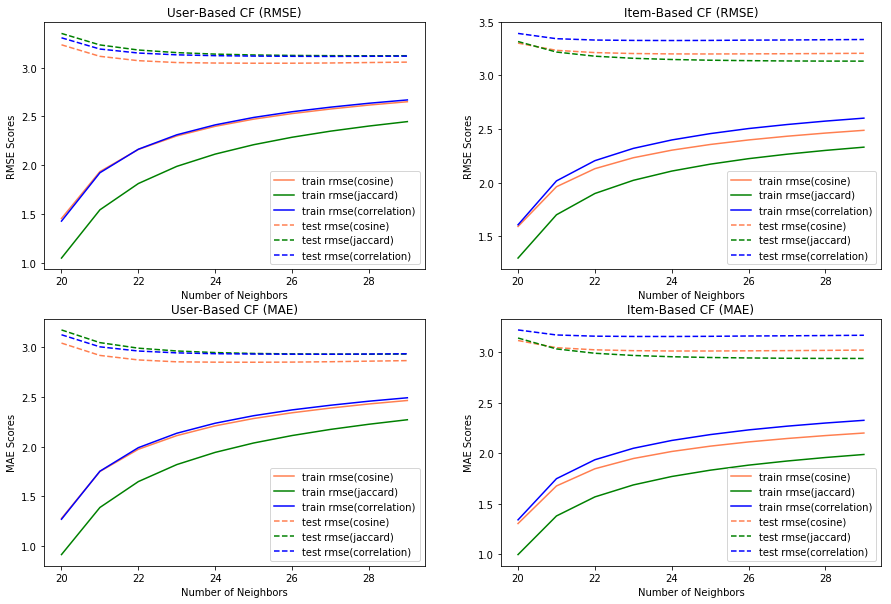

In [296]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.plot(Nneighbor,rmse_train[0:len(Nneighbor)],label='train rmse(cosine)',color='coral', linestyle='-')
plt.plot(Nneighbor,rmse_train[len(Nneighbor):2*len(Nneighbor)],label='train rmse(jaccard)',color='green', linestyle='-')
plt.plot(Nneighbor,rmse_train[2*len(Nneighbor):3*len(Nneighbor)],label='train rmse(correlation)',color='blue', linestyle='-')
plt.plot(Nneighbor,rmse_test[0:len(Nneighbor)],label='test rmse(cosine)',color='coral', linestyle='--')
plt.plot(Nneighbor,rmse_test[len(Nneighbor):2*len(Nneighbor)],label='test rmse(jaccard)',color='green', linestyle='--')
plt.plot(Nneighbor,rmse_test[2*len(Nneighbor):3*len(Nneighbor)],label='test rmse(correlation)',color='blue', linestyle='--')
plt.title('User-Based CF (RMSE)')
plt.xlabel('Number of Neighbors')
plt.ylabel('RMSE Scores')
plt.legend()

plt.subplot(222)
plt.plot(Nneighbor,rmse_train[3*len(Nneighbor):4*len(Nneighbor)],label='train rmse(cosine)',color='coral', linestyle='-')
plt.plot(Nneighbor,rmse_train[4*len(Nneighbor):5*len(Nneighbor)],label='train rmse(jaccard)',color='green', linestyle='-')
plt.plot(Nneighbor,rmse_train[5*len(Nneighbor):6*len(Nneighbor)],label='train rmse(correlation)',color='blue', linestyle='-')
plt.plot(Nneighbor,rmse_test[3*len(Nneighbor):4*len(Nneighbor)],label='test rmse(cosine)',color='coral', linestyle='--')
plt.plot(Nneighbor,rmse_test[4*len(Nneighbor):5*len(Nneighbor)],label='test rmse(jaccard)',color='green', linestyle='--')
plt.plot(Nneighbor,rmse_test[5*len(Nneighbor):6*len(Nneighbor)],label='test rmse(correlation)',color='blue', linestyle='--')
plt.title('Item-Based CF (RMSE)')
plt.xlabel('Number of Neighbors')
plt.ylabel('RMSE Scores')
plt.legend()

plt.subplot(223)
plt.plot(Nneighbor,mae_train[0:len(Nneighbor)],label='train rmse(cosine)',color='coral', linestyle='-')
plt.plot(Nneighbor,mae_train[len(Nneighbor):2*len(Nneighbor)],label='train rmse(jaccard)',color='green', linestyle='-')
plt.plot(Nneighbor,mae_train[2*len(Nneighbor):3*len(Nneighbor)],label='train rmse(correlation)',color='blue', linestyle='-')
plt.plot(Nneighbor,mae_test[0:len(Nneighbor)],label='test rmse(cosine)',color='coral', linestyle='--')
plt.plot(Nneighbor,mae_test[len(Nneighbor):2*len(Nneighbor)],label='test rmse(jaccard)',color='green', linestyle='--')
plt.plot(Nneighbor,mae_test[2*len(Nneighbor):3*len(Nneighbor)],label='test rmse(correlation)',color='blue', linestyle='--')
plt.title('User-Based CF (MAE)')
plt.xlabel('Number of Neighbors')
plt.ylabel('MAE Scores')
plt.legend()

plt.subplot(224)
plt.plot(Nneighbor,mae_train[3*len(Nneighbor):4*len(Nneighbor)],label='train rmse(cosine)',color='coral', linestyle='-')
plt.plot(Nneighbor,mae_train[4*len(Nneighbor):5*len(Nneighbor)],label='train rmse(jaccard)',color='green', linestyle='-')
plt.plot(Nneighbor,mae_train[5*len(Nneighbor):6*len(Nneighbor)],label='train rmse(correlation)',color='blue', linestyle='-')
plt.plot(Nneighbor,mae_test[3*len(Nneighbor):4*len(Nneighbor)],label='test rmse(cosine)',color='coral', linestyle='--')
plt.plot(Nneighbor,mae_test[4*len(Nneighbor):5*len(Nneighbor)],label='test rmse(jaccard)',color='green', linestyle='--')
plt.plot(Nneighbor,mae_test[5*len(Nneighbor):6*len(Nneighbor)],label='test rmse(correlation)',color='blue', linestyle='--')
plt.title('Item-Based CF (MAE)')
plt.xlabel('Number of Neighbors')
plt.ylabel('MAE Scores')
plt.legend()

plt.show()

## User-based CF

In [287]:
## Grid Search: user-based
Item_flag =[0]#,1]
Metric = ['cosine']#,'jaccard','correlation']
Nneighbor = np.arange(25,35,1)
param_grid = {'Item_flag':Item_flag, 'Metric': Metric,'Nneighbor':Nneighbor}
param_grid = list(ParameterGrid(param_grid))

scores_f = []
best_scores_rmse= float('inf')
best_scores_mae = float('inf')

start = time.time()
for j, param_set in enumerate(param_grid):
    print('--------------Start Parameter Set:',param_set.get('Nneighbor'),
          param_set.get('Metric'),param_set.get('Item_flag'),'----------------')
    knn = NearestNeighbors(metric=param_set.get('Metric'), algorithm='brute', 
                                 n_neighbors=param_set.get('Nneighbor'), n_jobs=-1)
    knn_cv = CV(knn,nneigh=param_set.get('Nneighbor'),nfolds=3,data=ratings_shuffle,
                verbose=1,item_flag=param_set.get('Item_flag'))
    scores_f.append(knn_cv)
    if best_scores_rmse > knn_cv[0]:
        best_scores_rmse = knn_cv[0]
        best_param_rmse = param_set
        
    if best_scores_mae > knn_cv[1]:
        best_scores_mae = knn_cv[1]
        best_param_mae = param_set
print("best parameter set is %s, with RMSE is %.4f" % (best_param_rmse, best_scores_rmse))
print("best parameter set is %s, with MAE is %.4f" % (best_param_mae, best_scores_mae))
print("finsied in %s seconds" %(time.time()-start))

--------------Start Parameter Set: 25 cosine 0 ----------------
--------------Start Parameter Set: 26 cosine 0 ----------------
--------------Start Parameter Set: 27 cosine 0 ----------------
--------------Start Parameter Set: 28 cosine 0 ----------------
--------------Start Parameter Set: 29 cosine 0 ----------------
--------------Start Parameter Set: 30 cosine 0 ----------------
--------------Start Parameter Set: 31 cosine 0 ----------------
--------------Start Parameter Set: 32 cosine 0 ----------------
--------------Start Parameter Set: 33 cosine 0 ----------------
--------------Start Parameter Set: 34 cosine 0 ----------------
best parameter set is {'Item_flag': 0, 'Metric': 'cosine', 'Nneighbor': 32}, with RMSE is 3.0437
best parameter set is {'Item_flag': 0, 'Metric': 'cosine', 'Nneighbor': 28}, with MAE is 2.8478
finsied in 80.5614869594574 seconds


In [289]:
rmse_test_2=[]
mae_test_2=[]
rmse_train_2=[]
mae_train_2=[]

for i in range(len(scores_f)):
    rmse_test_2.append(scores_f[i][0])
    mae_test_2.append(scores_f[i][1])
    rmse_train_2.append(scores_f[i][2])
    mae_train_2.append(scores_f[i][3])

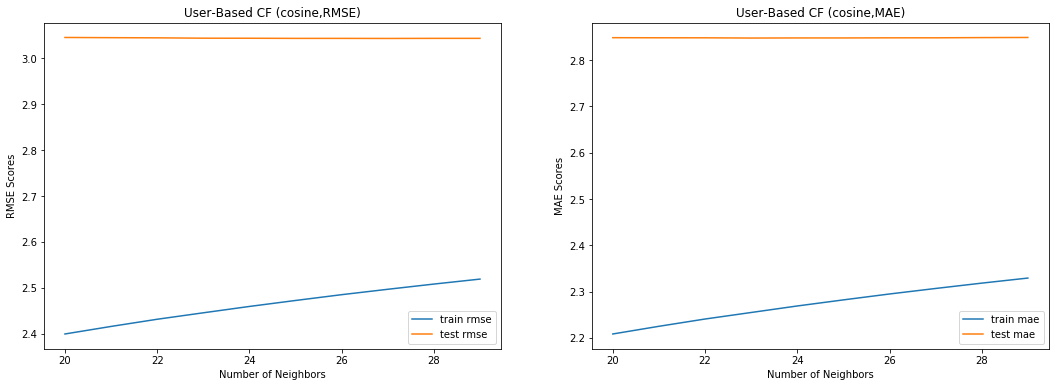

In [297]:
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.plot(Nneighbor,rmse_train_2,label='train rmse')#,color='coral', linestyle='-')
plt.plot(Nneighbor,rmse_test_2,label='test rmse')#,color='coral', linestyle='--')
plt.title('User-Based CF (cosine,RMSE)')
plt.xlabel('Number of Neighbors')
plt.ylabel('RMSE Scores')
plt.legend()

plt.subplot(122)
plt.plot(Nneighbor,mae_train_2,label='train mae')#,color='coral', linestyle='-')
plt.plot(Nneighbor,mae_test_2,label='test mae')#,color='coral', linestyle='--')
plt.title('User-Based CF (cosine,MAE)')
plt.xlabel('Number of Neighbors')
plt.ylabel('MAE Scores')
plt.legend()

plt.show()

In [311]:
start = time.time()
model_knn_user = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=32, n_jobs=-1)
knn_cv_user = CV(model_knn_user,nneigh=32,nfolds=5,data=ratings_shuffle,verbose=0,item_flag=0)
print("training time:",time.time()-start)

----Now processing fold: 1----
Fold 1 cost time 7.5670, train RMSE: 2.4287, calibration RMSE: 2.9010, train MAE: 2.2013, calibration MAE: 2.6795
----Now processing fold: 2----
Fold 2 cost time 3.6956, train RMSE: 2.4296, calibration RMSE: 2.8986, train MAE: 2.2023, calibration MAE: 2.6715
----Now processing fold: 3----
Fold 3 cost time 2.8920, train RMSE: 2.4299, calibration RMSE: 2.8953, train MAE: 2.2021, calibration MAE: 2.6713
----Now processing fold: 4----
Fold 4 cost time 2.7498, train RMSE: 2.4277, calibration RMSE: 2.8906, train MAE: 2.2007, calibration MAE: 2.6653
----Now processing fold: 5----
Fold 5 cost time 2.9403, train RMSE: 2.4250, calibration RMSE: 2.8991, train MAE: 2.1993, calibration MAE: 2.6735
training time: 20.17225480079651


In [312]:
print("average RMSE: {:.4f}, average MAE: {:.4f}".format(knn_cv_user[0],knn_cv_user[1]))

average RMSE: 2.8969, average MAE: 2.6722


## Item-Based CF

In [291]:
## Grid Search: item-based
Item_flag =[1]
Metric = ['jaccard']#,'correlation']
Nneighbor = np.arange(20,30,1)
param_grid = {'Item_flag':Item_flag, 'Metric': Metric,'Nneighbor':Nneighbor}
param_grid = list(ParameterGrid(param_grid))

scores_f = []
best_scores_rmse= float('inf')
best_scores_mae = float('inf')

start = time.time()
for j, param_set in enumerate(param_grid):
    print('--------------Start Parameter Set:',param_set.get('Nneighbor'),
          param_set.get('Metric'),param_set.get('Item_flag'),'----------------')
    knn = NearestNeighbors(metric=param_set.get('Metric'), algorithm='brute', 
                                 n_neighbors=param_set.get('Nneighbor'), n_jobs=-1)
    knn_cv = CV(knn,nneigh=param_set.get('Nneighbor'),nfolds=3,data=ratings_shuffle,
                verbose=1,item_flag=param_set.get('Item_flag'))
    scores_f.append(knn_cv)
    if best_scores_rmse > knn_cv[0]:
        best_scores_rmse = knn_cv[0]
        best_param_rmse = param_set
        
    if best_scores_mae > knn_cv[1]:
        best_scores_mae = knn_cv[1]
        best_param_mae = param_set
print("best parameter set is %s, with RMSE is %.4f" % (best_param_rmse, best_scores_rmse))
print("best parameter set is %s, with MAE is %.4f" % (best_param_mae, best_scores_mae))
print("finsied in %s seconds" %(time.time()-start))

--------------Start Parameter Set: 20 jaccard 1 ----------------
--------------Start Parameter Set: 21 jaccard 1 ----------------
--------------Start Parameter Set: 22 jaccard 1 ----------------
--------------Start Parameter Set: 23 jaccard 1 ----------------
--------------Start Parameter Set: 24 jaccard 1 ----------------
--------------Start Parameter Set: 25 jaccard 1 ----------------
--------------Start Parameter Set: 26 jaccard 1 ----------------
--------------Start Parameter Set: 27 jaccard 1 ----------------
--------------Start Parameter Set: 28 jaccard 1 ----------------
--------------Start Parameter Set: 29 jaccard 1 ----------------
best parameter set is {'Item_flag': 1, 'Metric': 'jaccard', 'Nneighbor': 29}, with RMSE is 3.1438
best parameter set is {'Item_flag': 1, 'Metric': 'jaccard', 'Nneighbor': 29}, with MAE is 2.9480
finsied in 1914.4996519088745 seconds


In [292]:
rmse_test_3=[]
mae_test_3=[]
rmse_train_3=[]
mae_train_3=[]

for i in range(len(scores_f)):
    rmse_test_3.append(scores_f[i][0])
    mae_test_3.append(scores_f[i][1])
    rmse_train_3.append(scores_f[i][2])
    mae_train_3.append(scores_f[i][3])

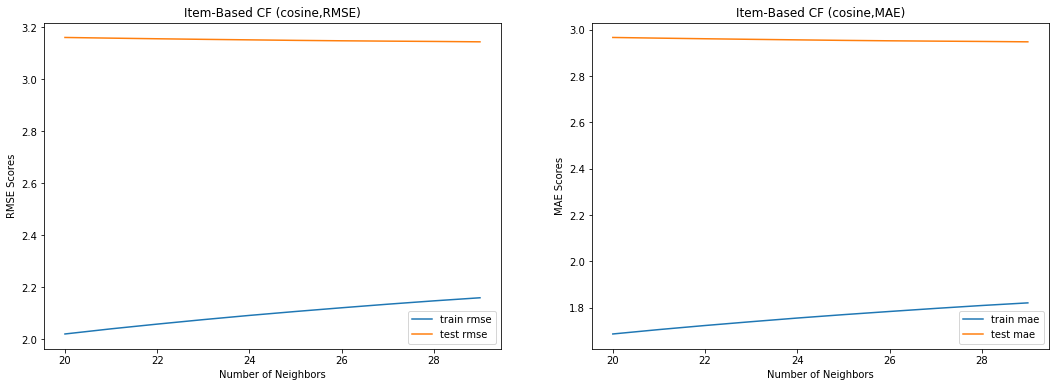

In [298]:
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.plot(Nneighbor,rmse_train_3,label='train rmse')#,color='coral', linestyle='-')
plt.plot(Nneighbor,rmse_test_3,label='test rmse')#,color='coral', linestyle='--')
plt.title('Item-Based CF (cosine,RMSE)')
plt.xlabel('Number of Neighbors')
plt.ylabel('RMSE Scores')
plt.legend()

plt.subplot(122)
plt.plot(Nneighbor,mae_train_3,label='train mae')#,color='coral', linestyle='-')
plt.plot(Nneighbor,mae_test_3,label='test mae')#,color='coral', linestyle='--')
plt.title('Item-Based CF (cosine,MAE)')
plt.xlabel('Number of Neighbors')
plt.ylabel('MAE Scores')
plt.legend()

plt.show()

In [301]:
kf=KFold(n_splits=3)
for j, (train_index, test_index) in enumerate(kf.split(ratings_shuffle)):
    train, test = ratings_shuffle.iloc[train_index], ratings_shuffle.iloc[test_index]
    

In [303]:
train,M_train = data_process(train,1)

In [304]:
train.shape

(8440, 610)

In [307]:
start = time.time()
model_knn_user = NearestNeighbors(metric='jaccard', algorithm='brute', n_neighbors=29, n_jobs=-1)
knn_cv_item = CV(model_knn_user,nneigh=29,nfolds=5,data=ratings_shuffle,verbose=0,item_flag=1)
print("training time:",time.time()-start)

----Now processing fold: 1----
Fold 1 cost time 130.3088, train RMSE: 2.0818, calibration RMSE: 2.9868, train MAE: 1.7198, calibration MAE: 2.7597
----Now processing fold: 2----
Fold 2 cost time 132.6782, train RMSE: 2.0800, calibration RMSE: 2.9893, train MAE: 1.7151, calibration MAE: 2.7579
----Now processing fold: 3----
Fold 3 cost time 140.5696, train RMSE: 2.0838, calibration RMSE: 2.9832, train MAE: 1.7219, calibration MAE: 2.7554
----Now processing fold: 4----
Fold 4 cost time 132.5378, train RMSE: 2.0839, calibration RMSE: 2.9852, train MAE: 1.7227, calibration MAE: 2.7542
----Now processing fold: 5----
Fold 5 cost time 155.6945, train RMSE: 2.0785, calibration RMSE: 2.9984, train MAE: 1.7179, calibration MAE: 2.7652
training time: 692.0831761360168


In [309]:
print("average RMSE: {:.4f}, average MAE: {:.4f}".format(knn_cv_item[0],knn_cv_item[1]))

average RMSE: 2.9886, average MAE: 2.7585
